# PySpark - GraphFrames and Graph Theory

## Introduction

Sometimes, it can be difficult to explain or better comprehend certain types of dataset or data problems with just a simple distribution charts, pie charts or scatter plots. These kinds of dataset can consists of geographical data points, social networks or user interactions. This is where graphs that consists of 3 components that are edges, nodes (or vertices) and their properties are utilised to represent these kinds of data problems in a more intuitive and easier way for comprehension. The ability to simply assign nodes to anything and define their relationship (between these nodes) with edges provides a great amount of flexibility to represent the data in a different way. This can also means that it is possible to connect two seemingly disparate graphs into a common graph, as long as there is a link that can be found between the nodes of the two disparate graphs. For example, joining a social network with restaurant reccomendations, number of travellers and airport delays etc.

For more information:
- https://www.geeksforgeeks.org/mathematics-graph-theory-basics-set-1/
- http://www.analytictech.com/mb021/graphtheory.htm

## Breakdown of this Notebook

- An Introduction to Graph Theory and GraphFrames for Apache Spark
- Installing GraphFrames
- Data Preparation
- Building the Graph
- Running querries against the graph
- Understanding the Graph
- Utilise PageRank to determine airport ranks
- Finding the fewest number of connections (flights)
- Visualising the Graph.

## Why use GraphFrames with Spark?

One of the main problems that persist when designing and computing graphs is that the traversal and computation of these graphing algorithms are ofthen computationally expensive and at times can be very slow. To overcome this, GraphFrams with Apache Spark is able to take advantage of the performance inherent of the DataFrames where it is distributed. 

### Under the hood of Graphframes:

GraphFrames utilises two Spark DataFrames where one would be used for the nodes and another for the edges, it leverages the optimisations and simplicity of the DataFrame API and in addition, it can be used and interacted with by other programming languages such as Python, Java and Scala APIs.

## Datasets:

The datasets for this project are the (1) Airline On-Time Performance and Causes of Flight Delays data which consists of information about scheduled and actual departure/arrival times along with the delay causes, and (2) OpenFlights data which details the airport and airlines. More details can be found in the link below.

The Datasets are obtained from:
- https://catalog.data.gov/dataset/airline-on-time-performance-and-causes-of-flight-delays-on-time-data or https://www.transtats.bts.gov/DL_SelectFields.asp?Table_ID=236&DB_Short_Name=On-Time
- https://openflights.org/data.html

Or download the folder from this repository which should contain the following files:
- airport-codes-na.txt
- departuredelays.csv

## 1 Installing GraphFrames:

GraphFrames Spark package can be found at the link: https://spark-packages.org/package/graphframes/graphframes. Where it uses PySpark to download the latest version, compile it and execute it within the context of the Spark Job.

At the time of writing this Notebook, the command was:

> $SPARK_HOME/bin/spark-shell --packages graphframes:graphframes:0.8.0-spark3.0-s_2.12

To install:
1. In a Terminal Window, after activating your PySpark Environment, type in "cd /your spark installed location/bin.
    - In my case it was "cd /opt/spark/bin
2. Change this part of the input: from 'spark-shell' to 'pyspark'
                    |
                    |
                    x
3. Then type in: pyspark --packages graphframes:graphframes:0.8.0-spark3.0-s_2.12
                 pyspark --master local --packages graphframes:0.8.0-spark3.0-s_2.12

## 2 PySpark Machine Configuration:

Here it only uses four processing cores from the CPU, and it set up by the following code.

In [1]:
%%configure
{
    "executorCores" : 4
}

In [2]:
from pyspark.sql.types import *

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
0,None,pyspark,idle,,,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## 3 Setup the Correct Directory:

In [3]:
import os

# Change the Path:
path = '++++your working directory here++++/Datasets/'
os.chdir(path)
folder_pathway = os.getcwd()

# print(folder_pathway)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## 4 Example of Nodes and Edges in Graphs:

The diagram below details the nodes and edges in a graph. 

Image source -> https://www.geeksforgeeks.org/mathematics-graph-theory-basics-set-1/


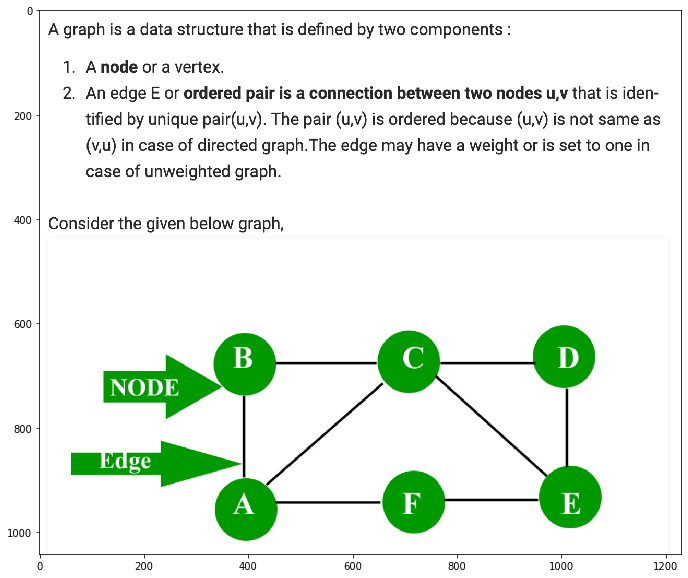

In [4]:
%%local

# Import the required library and set to use ggplot:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

folder_pathway = os.getcwd()
image_path = folder_pathway + "/Description Images/"

# plot the image
fig, ax1 = plt.subplots(figsize=(16,10))
image = mpimg.imread(image_path + 'Example Graph Theory.png')
plt.imshow(image);

print('Image source -> https://www.geeksforgeeks.org/mathematics-graph-theory-basics-set-1/')

## 5 Load in the Dataset:

Load in the data files from the "Datasets" folder. The ".txt" and ".csv" files are saved as "airports_original" and "departureDelays_original" respectively, where the schema is inddered and the headers are configured.


In [5]:
# Folder pathway:
dataset_pathway = folder_pathway + "/Datasets/"

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [6]:
# Airports Dataset:

airports_original = spark.read.csv(dataset_pathway + "/airport-codes-na.txt", header = 'true', inferSchema = 'true', sep = '\t')
airports_original.createOrReplaceTempView("airports_original")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [7]:
# Inspect:
airports_original.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+-----+-------+----+
|       City|State|Country|IATA|
+-----------+-----+-------+----+
| Abbotsford|   BC| Canada| YXX|
|   Aberdeen|   SD|    USA| ABR|
|    Abilene|   TX|    USA| ABI|
|      Akron|   OH|    USA| CAK|
|    Alamosa|   CO|    USA| ALS|
|     Albany|   GA|    USA| ABY|
|     Albany|   NY|    USA| ALB|
|Albuquerque|   NM|    USA| ABQ|
| Alexandria|   LA|    USA| AEX|
|  Allentown|   PA|    USA| ABE|
|   Alliance|   NE|    USA| AIA|
|     Alpena|   MI|    USA| APN|
|    Altoona|   PA|    USA| AOO|
|   Amarillo|   TX|    USA| AMA|
|Anahim Lake|   BC| Canada| YAA|
|  Anchorage|   AK|    USA| ANC|
|   Appleton|   WI|    USA| ATW|
|     Arviat|  NWT| Canada| YEK|
|  Asheville|   NC|    USA| AVL|
|      Aspen|   CO|    USA| ASE|
+-----------+-----+-------+----+
only showing top 20 rows

In [8]:
# Departure Delays Dataset:

departureDelays_original = spark.read.csv(dataset_pathway + "/departuredelays.csv", header = 'true', inferSchema = 'true')
departureDelays_original.createOrReplaceTempView("departureDelays_original")
departureDelays_original.cache()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

DataFrame[date: int, delay: int, distance: int, origin: string, destination: string]

In [9]:
# Inspect:
departureDelays_original.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- date: integer (nullable = true)
 |-- delay: integer (nullable = true)
 |-- distance: integer (nullable = true)
 |-- origin: string (nullable = true)
 |-- destination: string (nullable = true)

In [10]:
# Inspect:
departureDelays_original.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+-----+--------+------+-----------+
|   date|delay|distance|origin|destination|
+-------+-----+--------+------+-----------+
|1011245|    6|     602|   ABE|        ATL|
|1020600|   -8|     369|   ABE|        DTW|
|1021245|   -2|     602|   ABE|        ATL|
|1020605|   -4|     602|   ABE|        ATL|
|1031245|   -4|     602|   ABE|        ATL|
|1030605|    0|     602|   ABE|        ATL|
|1041243|   10|     602|   ABE|        ATL|
|1040605|   28|     602|   ABE|        ATL|
|1051245|   88|     602|   ABE|        ATL|
|1050605|    9|     602|   ABE|        ATL|
|1061215|   -6|     602|   ABE|        ATL|
|1061725|   69|     602|   ABE|        ATL|
|1061230|    0|     369|   ABE|        DTW|
|1060625|   -3|     602|   ABE|        ATL|
|1070600|    0|     369|   ABE|        DTW|
|1071725|    0|     602|   ABE|        ATL|
|1071230|    0|     369|   ABE|        DTW|
|1070625|    0|     602|   ABE|        ATL|
|1071219|    0|     569|   ABE|        ORD|
|1080600|    0|     369|   ABE| 

### NOTE: In the Section 6.3 below, a problem was encountered where "departureDelays_original" date column consists of integers and this is needed to be converted to strings for the purpose of using a user defined function to convert the time format.  

## 5.1 Fix the Date Column: from Integer to String.

In [11]:
departureDelays_original_str = departureDelays_original.withColumn("date", departureDelays_original["date"].cast(StringType()))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [12]:
departureDelays_original_str.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- date: string (nullable = true)
 |-- delay: integer (nullable = true)
 |-- distance: integer (nullable = true)
 |-- origin: string (nullable = true)
 |-- destination: string (nullable = true)

In [13]:
# Inspect:
departureDelays_original_str.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+-----+--------+------+-----------+
|   date|delay|distance|origin|destination|
+-------+-----+--------+------+-----------+
|1011245|    6|     602|   ABE|        ATL|
|1020600|   -8|     369|   ABE|        DTW|
|1021245|   -2|     602|   ABE|        ATL|
|1020605|   -4|     602|   ABE|        ATL|
|1031245|   -4|     602|   ABE|        ATL|
|1030605|    0|     602|   ABE|        ATL|
|1041243|   10|     602|   ABE|        ATL|
|1040605|   28|     602|   ABE|        ATL|
|1051245|   88|     602|   ABE|        ATL|
|1050605|    9|     602|   ABE|        ATL|
|1061215|   -6|     602|   ABE|        ATL|
|1061725|   69|     602|   ABE|        ATL|
|1061230|    0|     369|   ABE|        DTW|
|1060625|   -3|     602|   ABE|        ATL|
|1070600|    0|     369|   ABE|        DTW|
|1071725|    0|     602|   ABE|        ATL|
|1071230|    0|     369|   ABE|        DTW|
|1070625|    0|     602|   ABE|        ATL|
|1071219|    0|     569|   ABE|        ORD|
|1080600|    0|     369|   ABE| 

## 6 Data Pre-processing:

This stage is set to clean the datasets, where it should only include airport codes that are available within the flight data. This means that any airports that does not exist in the DepartureDelays.csv file are excluded.

The following code blocks are to filter out the data to build a "airports" DataFrame consisting of only vertices and edges, to be used with GraphFrames.

## 6.1 Extract the Relevant Airport codes: from departureDelays_original

This section will save the airport codes (IATA column of airports_original) from airports_original dataset that coincides with airports that exists in departureDelays_original dataset.

In [14]:
# Take available IATA codes from the departureDelays_original sample dataset:
iata = spark.sql("""
    SELECT DISTINCT iata FROM (SELECT DISTINCT origin AS iata FROM departureDelays_original
                                UNION ALL
                                SELECT DISTINCT destination AS iata FROM departureDelays_original) AS a
""")

iata.createOrReplaceTempView("iata")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [15]:
# Inspect:
iata.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----+
|iata|
+----+
| PSE|
| INL|
| MSY|
| PPG|
| GEG|
| BUR|
| SNA|
| GRB|
| GTF|
| IDA|
| GRR|
| JLN|
| EUG|
| PSG|
| GSO|
| MYR|
| PVD|
| OAK|
| BTM|
| COD|
+----+
only showing top 20 rows

## 6.2 Join the "iata" and "airports_original" DataFrames:

This section will create a new DataFrame called "airports_df" that consists of a join between "iata" and "airports_original" DataFrames. 

In [16]:
# Extract airports that has >1 trip from the departureDelays_original dataset:
airports = sqlContext.sql("""
    SELECT f.IATA,
    f.City,
    f.State,
    f.Country
    FROM airports_original AS f
    JOIN iata AS t
        ON t.IATA = f.IATA
""")

# Register DataFrame as Temporary table for use of SQL query:
airports.registerTempTable("airports")
airports.cache()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

DataFrame[IATA: string, City: string, State: string, Country: string]

In [17]:
# Inspect:
airports.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----+-------------------+-----+-------+
|IATA|               City|State|Country|
+----+-------------------+-----+-------+
| INL|International Falls|   MN|    USA|
| MSY|        New Orleans|   LA|    USA|
| GEG|            Spokane|   WA|    USA|
| BUR|            Burbank|   CA|    USA|
| SNA|      Orange County|   CA|    USA|
| GRB|          Green Bay|   WI|    USA|
| GTF|        Great Falls|   MT|    USA|
| IDA|        Idaho Falls|   ID|    USA|
| GRR|       Grand Rapids|   MI|    USA|
| JLN|             Joplin|   MO|    USA|
| EUG|             Eugene|   OR|    USA|
| GSO|         Greensboro|   NC|    USA|
| MYR|       Myrtle Beach|   SC|    USA|
| PVD|         Providence|   RI|    USA|
| OAK|            Oakland|   CA|    USA|
| BTM|              Butte|   MT|    USA|
| COD|               Cody|   WY|    USA|
| FAR|              Fargo|   ND|    USA|
| FSM|         Fort Smith|   AR|    USA|
| MQT|          Marquette|   MI|    USA|
+----+-------------------+-----+-------+
only showing top

## 6.3 Additional Optimisations:

The purpose of this stage is to create another DataFrame with further optimisations and it will be called "departureDelays_GEO". This will pack in the following optimisations for Graphing later on:

- Create a "tripid" column -> To identify each trip taken uniquely. This is done by converting the date into a integer column.
- Create a "data" column -> Here, the date format is MMYYHHmm and this will be processed to apply a "udf" format conversion first and then converted once more into the correct timestamp format.
- Conver the "delay" and "distance" columns -> Recast these columns that consist of integer values into strings.
- For Graphing purposes, the airport codes (that is the "iata" column) will be used as the vertex while the edges required the "IATA codes" for the originating airport and destination airports to be specified. This can be done with a "join" statement and the renaming of "f.origin" to be "src" coupled with "f.destination" to be "dst".

In [18]:
# Import the required libraries:
import pyspark.sql.functions as f
import pyspark.sql.types as t

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Specify a User Defined Function to convert the date formats:

The Date column shows the following "1011245" which will need to be converted into "2014-01-01T12:45:00.000+0000"
or "3050727" to be converted into "2014-03-05T07:25:00.000+0000" format. To do this, a function is created.

#### Test the output format with sample of the data from the date column:

In [19]:
badDate = '1011245'
badDate1 = '3050727'

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [20]:
@f.udf

def toDate_testing(badDate):
    year = '2014-'
    month = badDate[0:1] + '-'
    day = badDate[1:3] + ' '
    hour = badDate[3:5] + ':'
    minute = badDate[5:7] + ':00'
    
    return year + month + day + hour + minute

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [21]:
badDate_fixed = toDate_testing(badDate)
badDate_fixed

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Column<b'toDate_testing(1011245)'>

In [22]:
badDate_fixed = toDate_testing(badDate1)
badDate_fixed

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Column<b'toDate_testing(3050727)'>

#### Implement the function (udf): uses the "departureDelays_original_str" dataFrame and not the original.

In [23]:
@f.udf

def toDate(badDate_format):
    year = '2014-'
    month = str(badDate_format[0:1]) + '-'
    day = str(badDate_format[1:3]) + ' '
    hour = str(badDate_format[3:5]) + ':'
    minute = str(badDate_format[5:7]) + ':00'
    
    return year + month + day + hour + minute

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [24]:
# Apply the above function on the dataset:
departureDelays_original_str = departureDelays_original_str.withColumn('normalDate', toDate(departureDelays_original_str.date))

# Store a temporary Spark DF for Query:
departureDelays_original_str.createOrReplaceTempView("departureDelays_original_str")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [25]:
# Inspect:
departureDelays_original_str.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+-----+--------+------+-----------+------------------+
|   date|delay|distance|origin|destination|        normalDate|
+-------+-----+--------+------+-----------+------------------+
|1011245|    6|     602|   ABE|        ATL|2014-1-01 12:45:00|
|1020600|   -8|     369|   ABE|        DTW|2014-1-02 06:00:00|
|1021245|   -2|     602|   ABE|        ATL|2014-1-02 12:45:00|
|1020605|   -4|     602|   ABE|        ATL|2014-1-02 06:05:00|
|1031245|   -4|     602|   ABE|        ATL|2014-1-03 12:45:00|
|1030605|    0|     602|   ABE|        ATL|2014-1-03 06:05:00|
|1041243|   10|     602|   ABE|        ATL|2014-1-04 12:43:00|
|1040605|   28|     602|   ABE|        ATL|2014-1-04 06:05:00|
|1051245|   88|     602|   ABE|        ATL|2014-1-05 12:45:00|
|1050605|    9|     602|   ABE|        ATL|2014-1-05 06:05:00|
|1061215|   -6|     602|   ABE|        ATL|2014-1-06 12:15:00|
|1061725|   69|     602|   ABE|        ATL|2014-1-06 17:25:00|
|1061230|    0|     369|   ABE|        DTW|2014-1-06 12

### After the Date format has been fixed, Extract the key attributes of the flight data:

In [26]:
# Obtain the key attributes of a flight: creates the dataFrame "departureDelays_GEO"
# Attirbutes are  Date of flight, delays, distance, and airport information (Origin, Destination).

departureDelays_GEO = spark.sql("""
    SELECT cast(f.date as int) AS tripid,
    cast(f.normalDate as timestamp) AS `localdate`,
    cast(f.delay as int),
    cast(f.distance as int),
    f.origin AS src,
    f.destination AS dst,
    o.city AS city_src,
    d.city AS city_dst,
    o.state AS state_src,
    d.state AS state_dst
    FROM departureDelays_original_str AS f 
    JOIN airports AS o
    ON o.iata = f.origin
    JOIN airports AS d
    ON d.iata = f.destination
""")

# Store a temporary Spark DF for Query:
departureDelays_GEO.createOrReplaceTempView('departureDelays_GEO')

# Cache the DF and Count:
departureDelays_GEO.cache()
departureDelays_GEO.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

1361141

In [27]:
# Inspect:
departureDelays_GEO.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+-------------------+-----+--------+---+---+---------+--------+---------+---------+
| tripid|          localdate|delay|distance|src|dst| city_src|city_dst|state_src|state_dst|
+-------+-------------------+-----+--------+---+---+---------+--------+---------+---------+
|1011245|2014-01-01 12:45:00|    6|     602|ABE|ATL|Allentown| Atlanta|       PA|       GA|
|1020600|2014-01-02 06:00:00|   -8|     369|ABE|DTW|Allentown| Detroit|       PA|       MI|
|1021245|2014-01-02 12:45:00|   -2|     602|ABE|ATL|Allentown| Atlanta|       PA|       GA|
|1020605|2014-01-02 06:05:00|   -4|     602|ABE|ATL|Allentown| Atlanta|       PA|       GA|
|1031245|2014-01-03 12:45:00|   -4|     602|ABE|ATL|Allentown| Atlanta|       PA|       GA|
|1030605|2014-01-03 06:05:00|    0|     602|ABE|ATL|Allentown| Atlanta|       PA|       GA|
|1041243|2014-01-04 12:43:00|   10|     602|ABE|ATL|Allentown| Atlanta|       PA|       GA|
|1040605|2014-01-04 06:05:00|   28|     602|ABE|ATL|Allentown| Atlanta|       PA

## 7 Building the Graph:

Now that the DataFrames have been constructed, this section will proceed into building the graph itself.

To do this:
- Import the required libraries.
- First, is to use the "src" and "dst" columns from "" dataset to create edges within GraphFrames.
- Second, to rename the "airports_original" IATA column as "id" as this is a requirement for GraphFrames to identify vertices to be used.

Overall, for the creation of the GraphFrame, it will look for these columns:
- "id" column -> where it will identify the vertex (or node) and will join it to the "src" and "dst" columns. 
- "src" column -> would be the source of the vertex for the edges to be drawn.
- "dst" column -> will be the destination of the vertex for the edges to be connected to. 

Also, it will inherently have performance optimisations as these were implemented with two dataFrames.

### To run Graphframes or import the packages, the following "sc.addPyFile" must be included.

If there is trouble getting GraphFrames to work, please review the GraphFrames installation included.

In [28]:
sc.addPyFile('/opt/spark/jars/graphframes_graphframes-0.7.0-spark2.4-s_2.11.jar')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [29]:
# Import the required libraries:
from pyspark.sql.functions import *
from graphframes import *

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## 7.1 Create the Vertices dataFrame: from "airports_original" dataframe.

In [30]:
# Create the vertices:
vertices = airports_original.withColumnRenamed("IATA", "id").distinct()

# Cache it:
vertices.cache()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

DataFrame[City: string, State: string, Country: string, id: string]

## 7.2 Create the Edges dataFrame: from "departureDelays_GEO" dataframe.

In [31]:
# Create the edges:
edges = departureDelays_GEO.select("tripid", "delay", "src", "dst", "city_dst", "state_dst")

# Cache it:
edges.cache()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

DataFrame[tripid: int, delay: int, src: string, dst: string, city_dst: string, state_dst: string]

## 7.3 Build the Graph:

In [32]:
graph = GraphFrame(vertices, edges)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## 7.4 Examine the two DataFrames (Vertices and Edges):

In [33]:
# Vertices:
vertices.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------+-------+-------+---+
|          City|  State|Country| id|
+--------------+-------+-------+---+
|    Clarksburg|     WV|    USA|CKB|
|    Fort Dodge|     IA|    USA|FOD|
|       Redmond|     OR|    USA|RDM|
|        Valdez|     AK|    USA|VDZ|
|       Lebanon|     NH|    USA|LEB|
|         Aspen|     CO|    USA|ASE|
| Rouyn-Noranda|     PQ| Canada|YUY|
|       Iqaluit|Nunavut| Canada|YFB|
|       Toronto|     ON| Canada|YYZ|
|    Dillingham|     AK|    USA|DLG|
|   Fort Nelson|     BC| Canada|YYE|
|      Pellston|     MI|    USA|PLN|
|     St. Cloud|     MN|    USA|STC|
|St. Petersburg|     FL|    USA|PIE|
|    Great Bend|     KS|    USA|GBD|
|          Hilo|     HI|    USA|Big|
|       Kelowna|     BC| Canada|YLW|
|       Bemidji|     MN|    USA|BJI|
|        London|     ON| Canada|YXU|
|      Longview|     TX|    USA|GGG|
+--------------+-------+-------+---+
only showing top 20 rows

In [34]:
# Edges:
edges.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+-----+---+---+--------+---------+
| tripid|delay|src|dst|city_dst|state_dst|
+-------+-----+---+---+--------+---------+
|1011245|    6|ABE|ATL| Atlanta|       GA|
|1020600|   -8|ABE|DTW| Detroit|       MI|
|1021245|   -2|ABE|ATL| Atlanta|       GA|
|1020605|   -4|ABE|ATL| Atlanta|       GA|
|1031245|   -4|ABE|ATL| Atlanta|       GA|
|1030605|    0|ABE|ATL| Atlanta|       GA|
|1041243|   10|ABE|ATL| Atlanta|       GA|
|1040605|   28|ABE|ATL| Atlanta|       GA|
|1051245|   88|ABE|ATL| Atlanta|       GA|
|1050605|    9|ABE|ATL| Atlanta|       GA|
|1061215|   -6|ABE|ATL| Atlanta|       GA|
|1061725|   69|ABE|ATL| Atlanta|       GA|
|1061230|    0|ABE|DTW| Detroit|       MI|
|1060625|   -3|ABE|ATL| Atlanta|       GA|
|1070600|    0|ABE|DTW| Detroit|       MI|
|1071725|    0|ABE|ATL| Atlanta|       GA|
|1071230|    0|ABE|DTW| Detroit|       MI|
|1070625|    0|ABE|ATL| Atlanta|       GA|
|1071219|    0|ABE|ORD| Chicago|       IL|
|1080600|    0|ABE|DTW| Detroit|       MI|
+-------+--

## 8 Running Queries against the Graph:

With the graph created from calling the GraphFrames() function in the previous section, it is also possible to run some queries against the GraphFrame. This section will explore how this can be done. 

## 8.1 Query: Determine the number of airports.

In [45]:
print("Airports count: {}".format(graph.vertices.count()))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Airports count: 526

## 8.2 Query: Determine the number of fligths.

In [44]:
print("Trips count: {}".format(graph.edges.count()))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Trips count: 1361141

## 8.3 Query: Determine the number of flights that are delayed.

Here it is possible to use "filter" and "groupBy" clauses to obtain the data needed.

As the __Edges__ DataFrames has a "delay" column, for flights that are on-time, the filter can be set to "delay <=0", where as for delayed flights, the filter can be set to "delay > 0" 

In [48]:
print("Flights that are on-time: {}".format(
    graph.edges.filter("delay <= 0 ").count()
    )
)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Flights that are on-time: 780469

In [49]:
print("Flights that are delayed: {}".format(
    graph.edges.filter("delay > 0 ").count()
    )
)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Flights that are delayed: 580672

## 8.4 Query: Determine the number of flights that are delayed, but from San Francisco.

For this job, there are more filter requirements where it involves the "src" column and also to rearrange the average delay in descending order.

In [50]:
SanFranc_delays = (
    graph.edges
    .filter("src = 'SFO' AND delay > 0")
    .groupBy("src", "dst")
    .avg("delay")
    .sort(desc("avg(delay)"))
)

# Inspect:
SanFranc_delays.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---+---+------------------+
|src|dst|        avg(delay)|
+---+---+------------------+
|SFO|OKC|59.073170731707314|
|SFO|JAC| 57.13333333333333|
|SFO|COS|53.976190476190474|
|SFO|OTH| 48.09090909090909|
|SFO|SAT|            47.625|
|SFO|MOD| 46.80952380952381|
|SFO|SUN|46.723404255319146|
|SFO|CIC| 46.72164948453608|
|SFO|ABQ|           44.8125|
|SFO|ASE|44.285714285714285|
|SFO|PIT|            43.875|
|SFO|MIA| 43.81730769230769|
|SFO|FAT| 43.23972602739726|
|SFO|MFR| 43.11848341232228|
|SFO|SBP| 43.09770114942529|
|SFO|MSP|42.766917293233085|
|SFO|BOI| 42.65482233502538|
|SFO|RDM| 41.98823529411764|
|SFO|AUS|41.690677966101696|
|SFO|SLC|41.407272727272726|
+---+---+------------------+
only showing top 20 rows

## 9 Understanding the Graph

__Motifs__ can be used to discover patterns of different airports that are connected by its flights, this helps to explain the complex relationship of city airports and its flights.

To do this:
- It begins with a query, this will define the Motif by establishing that it is the relationship between vertices (a), (b) and (c) that are of interest. Specifically, the edges between the two vertices (a) and (b) as [ab], and that (b) and (c) as [bc].
- For example, to determine all the flights between 2 different cities, where LA is the lay over city. This means that it can be Seattle to LA (layover) then towards New York. Or Portland to LA (layover) towards Atlanta. In more detail:
    - (b) is LA
    - (a) is the originating city such as Seattle or Portland.
    - [ab] represents Seattle/Portland to LA (layover).
    - (c) is the destination city such as New York or Atlanta.
    - [bc] is LA (layover) to New York/Atlanta.
- In the code below, "b.id = 'SFO" is used to specify that San Francisco as the layover city.
- Also, trips between the originating city (a) and the layover city (b) have a delay greater than 500 minutes.
- Next, "bc.tripid > ab.tripid" and "bc.tripid < ab.tripid + 10000" are used to specify that the second leg of the trip have to occur after the first leg of the trip has completed.

In [52]:
# Make a Subset of the Graph:
edges_subset = departureDelays_GEO.select("tripid", "delay", "src", "dst")
graphSmall = GraphFrame(vertices, edges_subset)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [53]:
# Executiong of the Motif:
motifs = (
    graphSmall
    .find("(a)-[ab]->(b); (b)-[bc]->(c)")
    .filter("""
        (b.id = 'SFO')
        AND (ab.delay > 500 OR bc.delay > 500)
        AND bc.tripid > ab.tripid
        AND bc.tripid < ab.tripid + 10000
    """)
)

# Inspect:
motifs.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+--------------------+--------------------+--------------------+
|                   a|                  ab|                   b|                  bc|                   c|
+--------------------+--------------------+--------------------+--------------------+--------------------+
|[Albuquerque, NM,...|[1020600, 0, ABQ,...|[San Francisco, C...|[1021507, 536, SF...|[New York, NY, US...|
|[Albuquerque, NM,...|[1210815, -12, AB...|[San Francisco, C...|[1211508, 593, SF...|[New York, NY, US...|
|[Eureka, CA, USA,...|[1011635, -15, AC...|[San Francisco, C...|[1021507, 536, SF...|[New York, NY, US...|
|[Eureka, CA, USA,...|[1012016, -4, ACV...|[San Francisco, C...|[1021507, 536, SF...|[New York, NY, US...|
|[Eureka, CA, USA,...|[1020531, -2, ACV...|[San Francisco, C...|[1021507, 536, SF...|[New York, NY, US...|
|[Eureka, CA, USA,...|[1020948, -11, AC...|[San Francisco, C...|[1021507, 536, SF...|[New York, NY, US...|
|[Eureka, CA, USA,...|[1021506, -3, A

### Observation:

As it can be seen of the output, it denotes all of the flights that layover in San Francisco, additionally the flight delays are greater than 500 minutes for either arriving and leaving San Francisco.

## 9.1 Review the output of the first row:

In [56]:
motifs.take(1)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[Row(a=Row(City='Albuquerque', State='NM', Country='USA', id='ABQ'), ab=Row(tripid=1020600, delay=0, src='ABQ', dst='SFO'), b=Row(City='San Francisco', State='CA', Country='USA', id='SFO'), bc=Row(tripid=1021507, delay=536, src='SFO', dst='JFK'), c=Row(City='New York', State='NY', Country='USA', id='JFK'))]

### Breaking it down:

For __a__=Row(City='Albuquerque', State='NM', Country='USA', id='ABQ') -> noted as a __Airport__

For __ab__=Row(tripid=1020600, delay=0, src='ABQ', dst='SFO') -> noted as a __Flights__

For __b__=Row(City='San Francisco', State='CA', Country='USA', id='SFO') -> noted as a __Airport__

For  __bc__=Row(tripid=1021507, delay=536, src='SFO', dst='JFK') -> noted as a __Flights__

For  __c__=Row(City='New York', State='NY', Country='USA', id='JFK') -> noted as a __Airport__

#### From the above, it can be described as,

The flight departing from Albuquerque to San Francisco have no delays, however, the following connecting flight to New York can be delayed up to 536 minutes.

## 10 Using PageRank to determine the Airport Ranking:

The PageRank algorithm has been used in Google's Search Engine where it is a vote by all of the other pages on the Web, that determines how important a page can be. PageRank can be used in any graph to identify most influential and important nodes/vertices. Here, PageRank can be applied towards other problems where it will be used to determine Airport Ranking. 

There are important points about PageRank: 
1. PageRank does not take any weight (on edges and nodes) into the consideration.
2. If you have a weighted graph, all weights are ignores and the algorithm still works fine.
3. PageRank uses the directions. Hence directed graphs are the best fit for this algorithm.
4. Duplicated edges play role. In our example, if  x has called y twice,  in the graph there will be  two edges initiated from x to y. And if x contacted z only once ( which results in having single edge between x and z), in this case PageRank score for y will be higher than z, and it means y is more important than z.  So make sure what duplication means in your dataset.
5. PageRank algorithm in PySpark, does not generate DataFrame. In fact it generates a Graph with a new attribute/weight assigned to its nodes called PageRank where calculated PageRank scores are stored. And edge weights are normalized based on number of edges.

The above is sourced from: https://pysparktutorial.blogspot.com/2017/10/graphframes-pyspark.html

PageRank consists of two types of implementations that are:
- One that uses the GraphFrame interface to run PageRank for a fixed number of iterations. This is set by the parameter "maxIter". __(This will be used here)__
- Second, is by "org.apache.spark.graphx.Pregel" interface to run PageRank until the algorithm converges. This is set by the parameter "tol".

To do this:
- Use the number of flights and connections that are to and from various ariports.
- By using the GraphFrame interface, the first parameter is "resetProbability", where at default is 0.15 and it represents the probabilty of resetting to a random vertex/node. If the value > 0.15, it could mean a onger time to compute or if the value < 0.15, it could mean that it may overshoot and will not converge. The second parameter is. "maxIter", where at default is 5, as a greater value is used would mean a greater probability for more precise calculations.

## 10.1 Determine the most important airport:

In [58]:
ranks = graph.pageRank(resetProbability = 0.15, maxIter = 5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## 10.2 Plot the chart:

In [99]:
# Get the top 10 highly ranked Airports:
ranks_df_top10 = (
    ranks.vertices.orderBy(ranks.vertices.pagerank.desc())
    .limit(10)
)

ranks_df_top10.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------+-----+-------+---+------------------+
|          City|State|Country| id|          pagerank|
+--------------+-----+-------+---+------------------+
|       Atlanta|   GA|    USA|ATL|30.852689637281415|
|        Dallas|   TX|    USA|DFW| 22.35090825185797|
|       Chicago|   IL|    USA|ORD|21.476110490648225|
|        Denver|   CO|    USA|DEN|15.864147080276451|
|   Los Angeles|   CA|    USA|LAX|14.200409160093676|
|       Houston|   TX|    USA|IAH|13.038206739080561|
| San Francisco|   CA|    USA|SFO|11.262952692947371|
|       Phoenix|   AZ|    USA|PHX| 10.61464841238288|
|Salt Lake City|   UT|    USA|SLC|  9.46228920900108|
|     Las Vegas|   NV|    USA|LAS| 8.571473320234631|
+--------------+-----+-------+---+------------------+

In [94]:
# Step 1 - Calculate for the Scatter plot:
AirportRanks_calc = (
    ranks_df_top10
    .select('City', 'pageRank')
)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [95]:
# Step 2 - Register the Temporary Table:
AirportRanks_calc.registerTempTable('bar_plt')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [96]:
AirportRanks_calc.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------+------------------+
|          City|          pageRank|
+--------------+------------------+
|       Atlanta|30.852689637281415|
|        Dallas| 22.35090825185797|
|       Chicago|21.476110490648225|
|        Denver|15.864147080276451|
|   Los Angeles|14.200409160093676|
|       Houston|13.038206739080561|
| San Francisco|11.262952692947371|
|       Phoenix| 10.61464841238288|
|Salt Lake City|  9.46228920900108|
|     Las Vegas| 8.571473320234631|
+--------------+------------------+

### STEP 3 - Use Magic SQL

In [97]:
%%sql -o bar_plt -q
SELECT * FROM bar_plt

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Step 4 - Produce the Scatter Plot:

Text(0.5, 1.0, 'Airports Ranked')

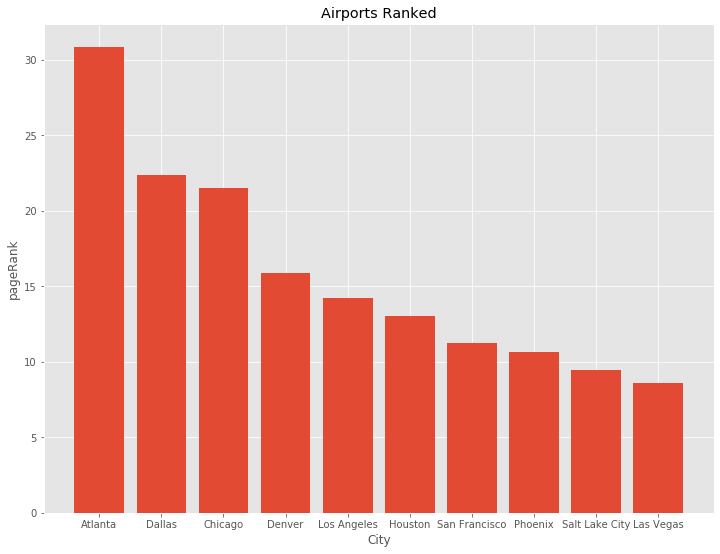

In [98]:
%%local

# Import the required library and set to use ggplot:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

# Plot:
fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(1, 1, 1)
ax.bar(
    list(bar_plt['City']), list(bar_plt['pageRank'])
)
ax.set_xlabel('City')
ax.set_ylabel('pageRank')
ax.set_title('Airports Ranked')

### Observation:

Here it can be seen that Atlanta, Dallas and Chicago are the three top most ranked and therefore are important cities.

## 11 Finding the fewest number of Connections:

In [ ]:
%%local

# plot the image
fig, ax1 = plt.subplots(figsize=(16, 10))
image = mpimg.imread(image_path + 'Microbatch lines of DStream.png')
plt.imshow(image);

print('Image source -> ')